# Predicting Who Survived the Titanic
Data: Kaggle Titantic Data Set
#### Author: James Ogle
Date: 9/18/2205

#### Description:
There were two models developed in the jupyter notebook, one is a self made logistic regression model and the other the standard scikit-learn logistic regression model. The Sklearn model performed about 1% better than the self-developed model for the test accuracy in kaggle.

#### New Objective:
- update train to include regularization parameters and lamba
- update compute cost, include regularization
  - try both L1 or L2
- repeat Logistic Regression and regularization experiments with SKLearn implementation

#### Loading Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import joblib

## Read in & Clean Data
- removes cabin, passenger id, name, and ticket columns
- some cells in embarked are null so won't need to remove all but can just remove those rows

#### Functions for Prepping Data

In [2]:
# Removes null values and normalizes data
def clean_data (data):
  if 'Cabin' in data.columns:
    data = data.drop('Cabin', axis=1)
  data = data.dropna()
  data['Fare'] = standard_scalar_normalize(data['Fare'])
  data['Age'] = min_max_normalize(data['Age'])
  return data

# Stores and one-hot encodes appropriate columns into X data
def X_data (data):
  columns_select = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
  X = data[columns_select]
  X = X.dropna()
  X = pd.get_dummies(X, columns=['Sex', 'Embarked'], dtype=int, drop_first=True)
  return X

# stores appropriate column into y
def y_data (data):
  y = data['Survived']
  return y

def min_max_normalize (column):
  min_val = column.min()
  max_val = column.max()
  normalized_col = (column - min_val) / (max_val - min_val)
  return normalized_col

def standard_scalar_normalize (column):
  mean = column.mean()
  std = column.std()
  normalized_col = (column - mean) / std
  return normalized_col

# Splits the data by random index, train_size will represent size of training set
# input training size as a decimal, e.g. 0.7 for 70%
def split_data (X, y, train_size, random_state=42):
  totalRows = X.shape[0]
  # create random indicies for X and y samples
  indicies = np.random.permutation(totalRows)


  splitPoint = int(totalRows * train_size)
  train_indicies = indicies[:splitPoint]
  val_indicies = indicies[splitPoint:]


  X_train = X.iloc[train_indicies]
  y_train = y.iloc[train_indicies]
  X_val = X.iloc[val_indicies]
  y_val = y.iloc[val_indicies]
  return X_train, y_train, X_val, y_val

# Plots a box plot, histogram, and scatter based on the column passed in
def get_info (column):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18, 5))
  ax1.boxplot(column.dropna())
  ax1.set_title(f"Distribution of {column.name}")
  ax1.set_ylabel("Value")

  ax2.hist(column.dropna(), bins=20)
  ax2.set_title(f"Histogram of {column.name}")
  ax2.set_ylabel("Frequency")
  ax2.set_xlabel("Value")

  ax3.scatter(np.arange(len(column.dropna())), column.dropna())
  ax3.set_title(f"{column.name} Values")
  ax3.set_ylabel("Value")
  ax3.set_xlabel("")

  plt.tight_layout(pad=3.0)
  plt.savefig(f"{column.name}_distribution.png")
  plt.show()
  return column.std()

# Rather than getting rid of null values, this function will replace
# null values with the mean of the column
def replace_null(data):
  if 'Cabin' in data.columns:
    data = data.drop('Cabin', axis=1)

  for column in data.columns:
    if data[column].isnull().any():
        data[column] = data[column].fillna(data[column].median())
  return data


#### Reading in Data

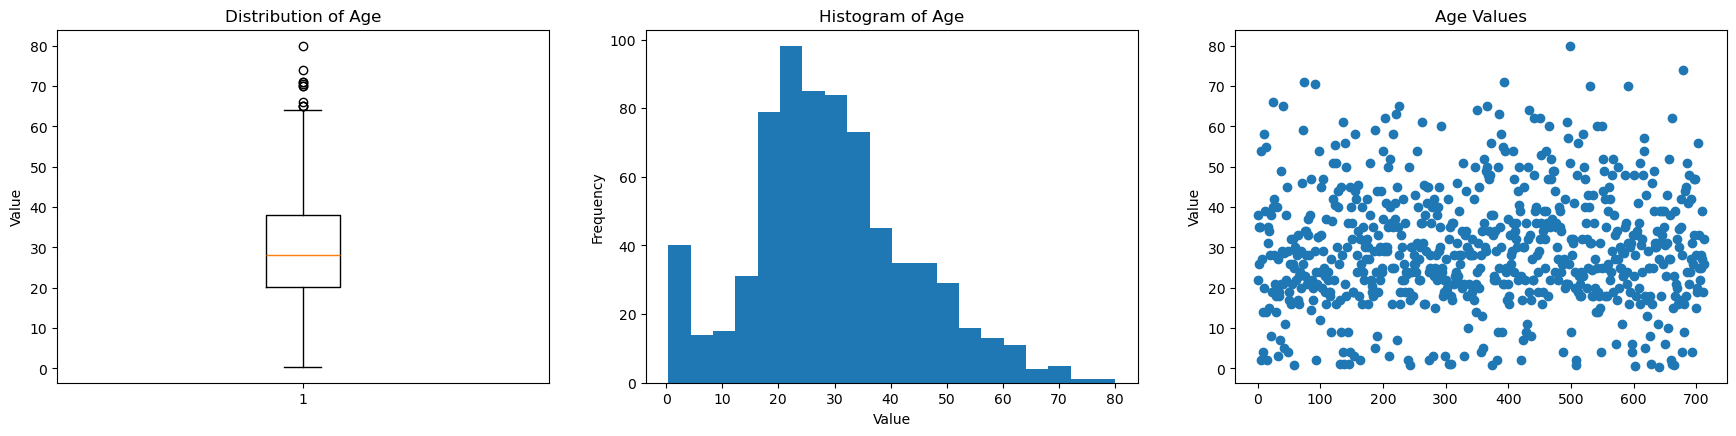

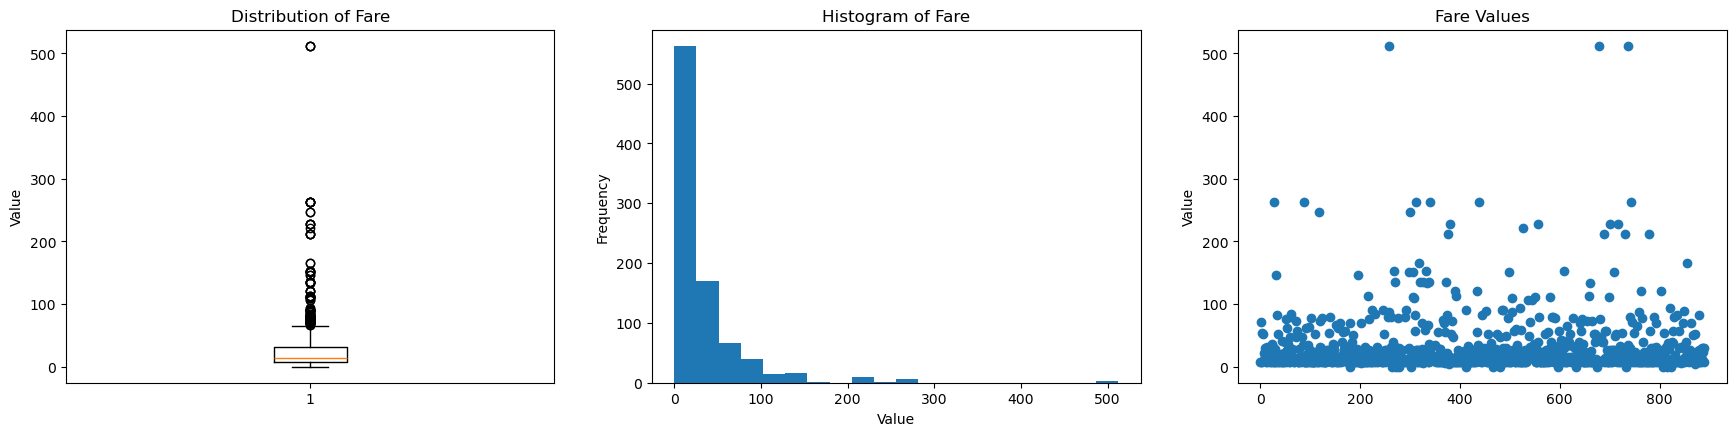

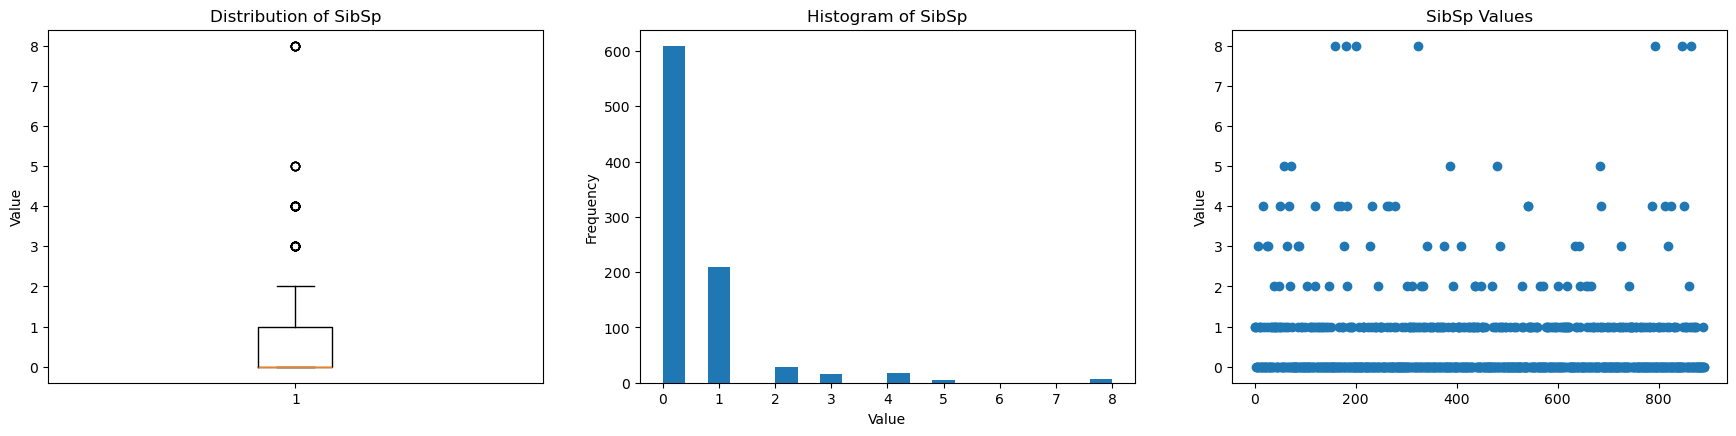

Standard Deviation of Age: 14.5265
Standard Deviation of Fare: 49.6934
Standard Deviation of SibSp: 1.1027



In [3]:
sample_data = pd.read_csv("./titanic-data/train.csv")
#########################################################################
# Determine Normalization Factor data columns which will be used in clean_data function
std_dev_age = get_info(sample_data['Age'])
std_dev_fare = get_info(sample_data['Fare'])
std_dev_sibSp = get_info(sample_data['SibSp'])
print(f"Standard Deviation of Age: {std_dev_age:.4f}\n"
      f"Standard Deviation of Fare: {std_dev_fare:.4f}\n"
      f"Standard Deviation of SibSp: {std_dev_sibSp:.4f}\n")

#### What the Whisker Plot Tells Us
Distribution of Fare:
- the data is heavily skewed to the right, meaning a standard scalar normalization will be the best fit
- a min-max scaler would most likely cause a loss of data meaning for the lower values
- The data in fare also has a pretty high standard deviation
- one issue that might occur from this is fare being the only column with negative numbers

Distribution of Age:
-  Due to age having a norma standard deviation and fewer set of outliers, min-max will most likely be the best choice for this column
-  keeping the range between [0,1] might also prove more beneficial by staying within the range of other column values that will be one-hot encoded

SibSp:
- represents the number of sibling or spouse the passenger had on the titanic
- will choose not to normalize it since the standard deviation of the data is not too great
- the values also have a small range of 0,8 which should not effect the convergence

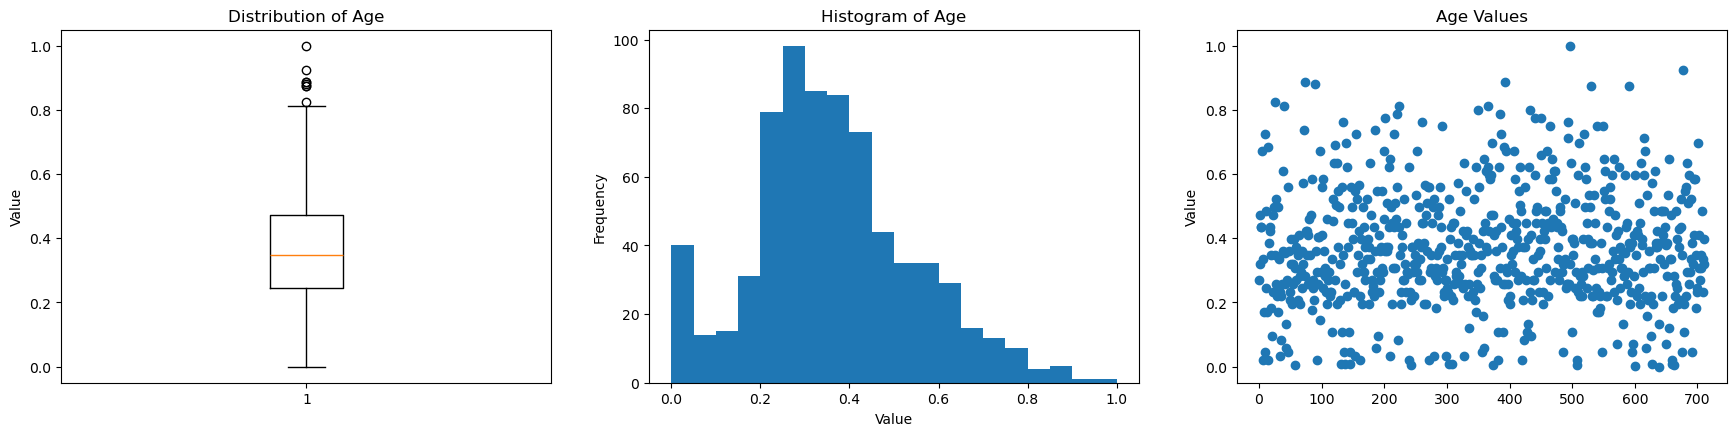

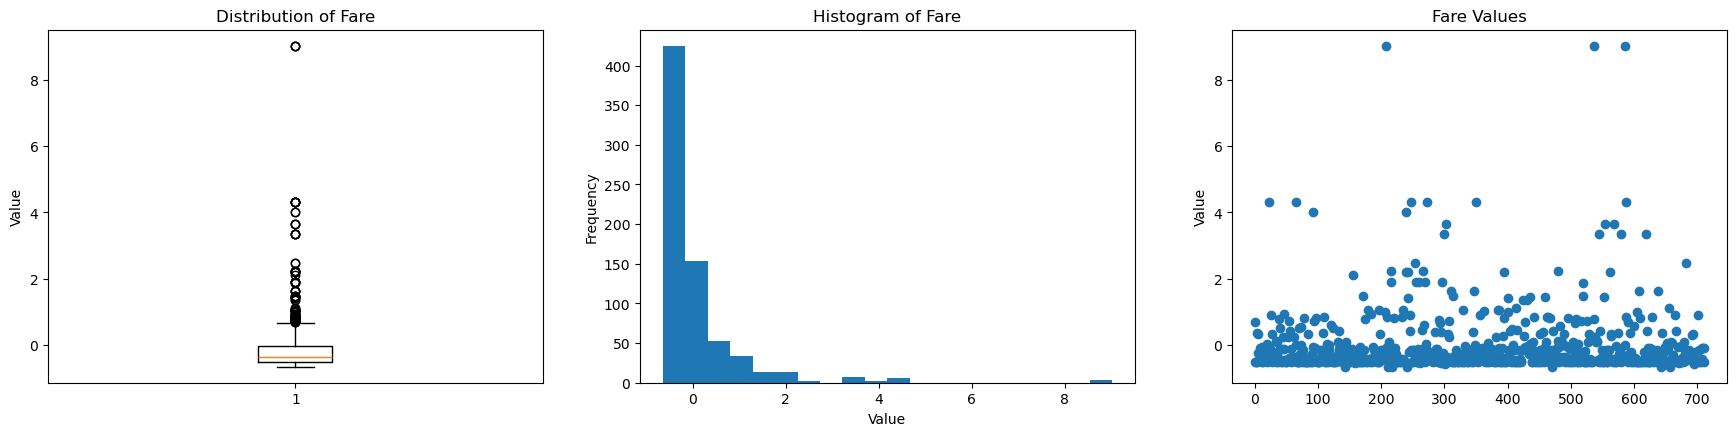

Standard Deviation of Age: 0.1821
Standard Deviation of Fare: 1.0000



In [4]:
sample_data = clean_data(sample_data)
#########################################################################
# Data after cleaning and normalizing
std_dev_age = get_info(sample_data['Age'])
std_dev_fare = get_info(sample_data['Fare'])
print(f"Standard Deviation of Age: {std_dev_age:.4f}\n"
      f"Standard Deviation of Fare: {std_dev_fare:.4f}\n")

#### Feature Scaling

In [5]:
X_sample = X_data(sample_data)

y_sample = y_data(sample_data)
X_train, y_train, X_val, y_val = split_data(X_sample, y_sample, 0.7)
print(X_train.shape)

# Sex_female and Embarked_C not included due to drop_first being set to True
print(f"Training data after one-hot encoding and min-max normalizing Age and Fare column:\n\n{X_train.head()}")

(498, 8)
Training data after one-hot encoding and min-max normalizing Age and Fare column:

     Pclass       Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  \
591       1  0.648153      1      0  0.825473         0           0   
688       3  0.220910      0      0 -0.505707         1           0   
412       1  0.409399      1      0  1.047113         0           1   
124       1  0.673285      0      1  0.806977         1           0   
875       3  0.183212      0      0 -0.516489         0           0   

     Embarked_S  
591           0  
688           1  
412           0  
124           1  
875           0  


## Sci-kit Learn Model

#### Logistic Regression with Sklearn

Logistic Regression Accuracy:
0.82

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        82
           1       0.84      0.70      0.77        61

    accuracy                           0.82       143
   macro avg       0.82      0.80      0.81       143
weighted avg       0.82      0.82      0.82       143




['titanic_survivor_pred.pkl']

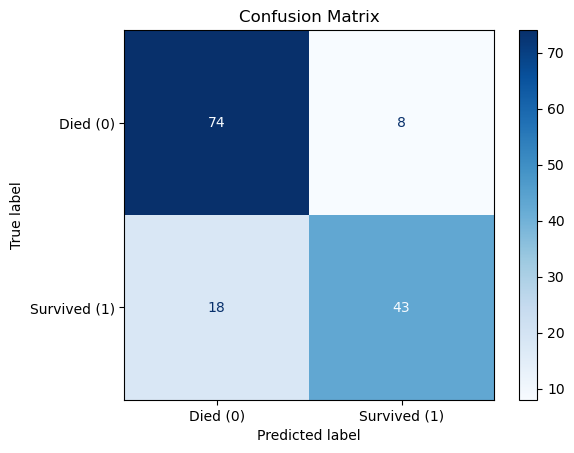

In [6]:
model = LogisticRegression(max_iter=10000, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_sample, y_sample, test_size=0.2, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print(f"Logistic Regression Accuracy:\n{accuracy_score(y_val, y_pred):.2f}\n")
print(f"Classification Report:\n{classification_report(y_val, y_pred)}\n")

# Confusion Matrix for determining false positives/negatives
cm = confusion_matrix(y_val, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Died (0)', 'Survived (1)'])
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_sk_model.png')
plt.show
joblib.dump(model, "titanic_survivor_pred.pkl")

#### Testing Model

In [7]:
test_data = pd.read_csv("./titanic-data/test.csv")
test_data_clean = replace_null(test_data)
test_data_clean = clean_data(test_data_clean)
test_data_id = test_data_clean['PassengerId'].copy()
X_test = X_data(test_data_clean)

loaded_model = joblib.load("titanic_survivor_pred.pkl")
survivor_pred = loaded_model.predict(X_test)

results = pd.DataFrame ( {
  'PassengerId': test_data_id,
  'Survived': survivor_pred
} )
print(results.head())
results.to_csv('sklearn_prediction.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1


## Self-Made Logistic Regression Model

#### Functions for Logistic Regression

In [8]:
def sigmoid(z):
  # returns the probability of survival
  sigmoid = 1 / (1 + np.exp(-z))
  return sigmoid


def initialize_params(m_features, seed=42):
  #   returns vector (w) of size (m x 1) features with small random numbers, and the scalar b initialized to 0
  #   -> b = 0
  # (0, 0.1) represents a Gaussian distribution with mean 0 and std 0.01
  # w = np.random.default_rng(seed).normal(0, 0.1, size=(m_features, 1))
  w = np.random.default_rng(seed).normal(size=(m_features, 1))

  b = 0
  return w, b


def forward(X, w, b):
  # Returns the probability value
  # > 0.5 -> survived
  # < 0.5 -> did not survive
  X = X.to_numpy()
  z = np.dot(X, w) + b
  y_hat = sigmoid(z)
  return y_hat, z


def compute_cost(y, y_hat, w, eps=1e-12, reg_lambda=0.01):
  # computes binary cross-entropy cost
  n = y.shape[0]
  y = y.to_numpy()
  y = y.reshape(n, 1)
  y_hat = np.clip(y_hat, eps, 1 - eps) # prevents log(0) which results in infinite value

  # L2 Regularization implement with cost function help prevent minor overfitting
  penalty_term = reg_lambda * np.sum(w ** 2)
  cost = -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)) + penalty_term

  return cost


def compute_gradients(X, y, y_hat, w, reg_lambda=0.0):
  X = X.to_numpy()
  n = X.shape[0]  # represents num of features
  y = y.to_numpy() # converts y from series
  y = y.reshape(n, 1) # matches y with y_hat
  pred_difference = y_hat - y
  dw = (1 / n) * np.dot(X.T, pred_difference) + (reg_lambda / n) * w
  db = (1 / n) * (y_hat - y).sum()  # .sum() allows us to take a sum of differences between prediction and target
  return dw, db


def update_params(w, b, dw, db, lr):
  # Gradient steps used for updating the parameters
  w = w - (lr * dw)
  b = b - (lr * db)
  return w, b


def train(X, y, lr, n_epochs, reg_lambda=0.0, X_val=None, y_val=None):
  #   I. training loop
  #       1.) forward pass
  #       2.) compute cost
  #       3.) compute gradients
  #       4.) update parameters
  features = X.shape[1]
  w, b = initialize_params(features, seed=42)
  train_cost_history = []
  valid_cost_history = []

  for epoch in range(n_epochs):
    y_hat, z = forward(X, w, b)
    cost = compute_cost(y, y_hat, w)
    train_cost_history.append(cost)

    if X_val is not None and y_val is not None:
      y_hat_val, z_val = forward(X_val, w, b)
      cost_val = compute_cost(y_val, y_hat_val, w)
      valid_cost_history.append(cost_val)

    dw, db = compute_gradients(X, y, y_hat, w, reg_lambda)
    w, b = update_params(w, b, dw, db, lr)

  #   II. Returns the trained parameters 'w' and 'b' and history of the cost for training and validation sets
  return w, b, train_cost_history, valid_cost_history


# will be used for testing accuracy of models
def predict_proba(X, w, b):
  X = X.to_numpy()
  z = np.dot(X, w) + b
  y_hat = sigmoid(z)
  return y_hat

#### Training Model

In [9]:
learning_rate = 0.007
n_epochs = 5000
valid_params, bias, train_cost, val_cost= train(X_train, y_train, learning_rate, n_epochs, reg_lambda=0.0, X_val=X_val, y_val=y_val)

#### Plotting Cost History

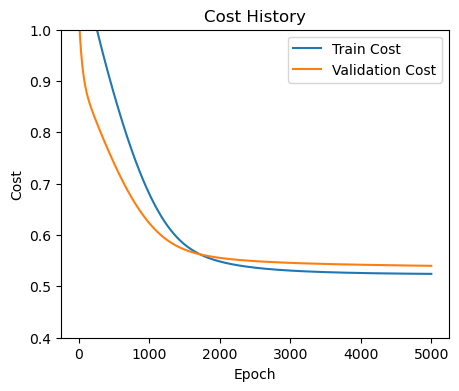

In [10]:
plt.figure(figsize=(5, 4))
plt.plot(range(n_epochs), train_cost, linewidth=1.5, label='Train Cost')
plt.plot(range(n_epochs), val_cost, linewidth=1.5, label='Validation Cost')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.ylim(0.4, 1)
plt.title('Cost History')
plt.legend()
plt.savefig('cost_history.png')
plt.show()

#### Accuracy with Traing Set

TRAINING DATA
Logistic Regression Accuracy:
0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       342
           1       0.77      0.68      0.72       227

    accuracy                           0.79       569
   macro avg       0.78      0.77      0.78       569
weighted avg       0.79      0.79      0.79       569




<function matplotlib.pyplot.show(close=None, block=None)>

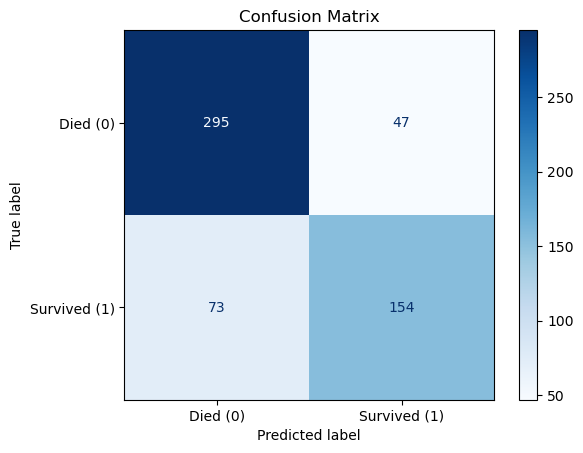

In [11]:
##########################################################################################
# Used for determining if my model is overfitting by comparing to validation results
y_hat = predict_proba(X_train, valid_params, bias)
y_train = np.asarray(y_train).astype(int)
y_hat = y_hat.reshape(-1)

for i, y in enumerate(y_hat):
  if y >= 0.5: y_hat[i] = 1 # did survive
  elif y < 0.5: y_hat[i] = 0 # did not survive

############################################################################################
# Displaying Accuracy
accuracy = (y_hat == y_train).mean()
print("TRAINING DATA")
print(f"Logistic Regression Accuracy:\n{accuracy_score(y_train, y_hat):.2f}\n")
print(f"Classification Report:\n{classification_report(y_train, y_hat)}\n")

cm = confusion_matrix(y_train, y_hat)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Died (0)', 'Survived (1)'])
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_sf_model_train.png')
plt.show

#### Accuracy with Validation Set

VALIDATION DATA
Logistic Regression Accuracy:
0.79

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83        82
           1       0.80      0.67      0.73        61

    accuracy                           0.79       143
   macro avg       0.79      0.78      0.78       143
weighted avg       0.79      0.79      0.79       143




['logistic_regr_model.pkl']

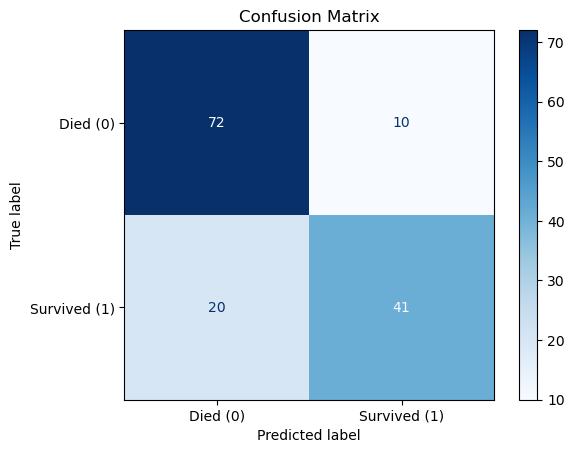

In [12]:
##########################################################################################
y_hat = predict_proba(X_val, valid_params, bias)
y_true = np.asarray(y_val).astype(int)
y_hat = y_hat.reshape(-1)

# Changes the y_hat to binary format
for i, y in enumerate(y_hat):
  if y >= 0.5: y_hat[i] = 1 # did survive
  elif y < 0.5: y_hat[i] = 0 # did not survive

############################################################################################
# Displaying Accuracy
accuracy = (y_hat == y_val).mean()
print("VALIDATION DATA")
print(f"Logistic Regression Accuracy:\n{accuracy_score(y_val, y_hat):.2f}\n")
print(f"Classification Report:\n{classification_report(y_val, y_hat)}\n")

# will be used for determining false positives/negatives
cm = confusion_matrix(y_val, y_hat)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Died (0)', 'Survived (1)'])
cm_display.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_sf_model.png')
plt.show

#############################################################################################
# Saving Model
self_made_model = np.append(valid_params, bias)
model_data = {
  'weights': valid_params,
  'bias': bias,
}
joblib.dump(model_data, "logistic_regr_model.pkl")


#### Read in Test Data

In [13]:
######################################################################
# Reads in and calls all functions necessary to clean up the data for testing
test_data = pd.read_csv("./titanic-data/test.csv")
test_data_clean = replace_null(test_data)
test_data_clean = clean_data(test_data_clean)
passenger_ids = test_data_clean['PassengerId'].copy()
X_test = X_data(test_data_clean)
print(X_test.head())

   Pclass       Age  SibSp  Parch      Fare  Sex_male  Embarked_Q  Embarked_S
0       3  0.452723      0      0 -0.496818         1           1           0
1       3  0.617566      1      0 -0.511665         0           0           1
2       2  0.815377      0      0 -0.463545         1           1           0
3       3  0.353818      0      0 -0.481898         1           0           1
4       3  0.287881      1      1 -0.416992         0           0           1


#### Run Test Data

In [14]:
survivor_probability = predict_proba(X_test, valid_params, bias)
survivor_predict = survivor_probability.copy()

for i, y in enumerate(survivor_predict):
  if y >= 0.5: survivor_predict[i] = 1 # did survive
  elif y < 0.5: survivor_predict[i] = 0 # did not survive

survivor_predict = survivor_predict.astype(int)
survivor_predict = survivor_predict.ravel()

results = pd.DataFrame ( {
  'PassengerId': passenger_ids,
  'Survived': survivor_predict
} )
print(results.head())
results.to_csv('submission_sm_LR.csv', index=False)

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         1
